In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import random
import time
import math
import random
import os
import sys
from datetime import datetime

# Notebook path
current_directory = os.getcwd()
# Get one behind for calling the other modules
root_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(root_directory)

#Network and measures
#from to_get_data.net_construction_vis_measures import *
#Agrobiodiversity
from to_get_data.agrobiodiversity_data import *

from model_class.Variety import Variety
from model_class.UD import UD

In [8]:
# Functions for the simulation.
#This is not used
def lista_em_listas(graph, node_id, nested_list):
    for item in nested_list:
        if isinstance(item, list):
            lista_em_listas(graph, node_id, item)
        elif item is not None:
            graph.add_edge(node_id, item)

#This "disentangles" the list of parents
def disentangle_function(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):
            result.extend(disentangle_function(item))
        elif item is not None:
            result.append(item)
    return result

#Big network. Network for exchange. If measures == True, get the measures
def create_vis_geral(uds_copy, measures=False):
    Gg = nx.Graph()

    # Alive
    ud_vivas = [ud for id, ud in uds_copy.items() if ud.activa == True]
    id_ud_vivas = [ud.id for ud in ud_vivas]

    for viva in ud_vivas:
        Gg.add_node(viva.id, ID=viva.id, age=viva.age, filhos=len(viva.parentes[2]) if viva.parentes[2] is not None else 0)
        for n in disentangle_function(viva.parentes[:9]):
            if n in id_ud_vivas:
                Gg.add_edge(viva.id, n)

    # Vis_graph
    pos = nx.spring_layout(Gg, k=1)
    node_labels = {node: f"ID: {Gg.nodes[node]['ID']}\nAge: {Gg.nodes[node]['age']}\nChildren: {Gg.nodes[node]['filhos']}" for node in Gg.nodes}
    plt.figure(figsize=(17, 10))
    nx.draw(Gg, pos, with_labels=True, node_size=4000, labels=node_labels, node_color='lightblue', font_size=8, font_color='black')
    plt.title(f"Network of the UDs. Nodes: {len(Gg.nodes)}")
    plt.show()
    
    if measures == True:
        # Centrality and general measures
        centralidad(Gg)
        gerais(Gg)
    print("----------------------------")
    
#Centralities  
def centralidad(Gg):
    # 1. Degree distribution and other measures
    # (betweenness centrality)
    betweenness_centrality = nx.betweenness_centrality(Gg)
    # (closeness centrality)
    closeness_centrality = nx.closeness_centrality(Gg)
    # (degree centrality)
    degree_centrality = nx.degree_centrality(Gg)
    # (Eigenvector centrality)
    eigenvector_centrality = nx.eigenvector_centrality(Gg)
    # Print first 10
    print("Betweenness Centrality:")
    print({k: v for k, v in sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)[:10]})

    print("\nCloseness Centrality:")
    print({k: v for k, v in sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)[:10]})

    print("\nDegree Centrality:")
    print({k: v for k, v in sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:10]})

    print("\nEigenvector Centrality:")
    print({k: v for k, v in sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)[:10]})

    degree_sequence = [d for n, d in Gg.degree()]
    plt.hist(degree_sequence, bins='auto', alpha=0.7, color='blue', edgecolor='black')
    plt.title('Distribucao do degree no Gg')
    plt.xlabel('Degree')
    plt.ylabel('Frecuencia')
    plt.show()
    
#General measures
def gerais(Gg):
    # 2. General measures
    # Densidad
    density = nx.density(Gg)

    # Nodes and edges
    num_nodes = Gg.number_of_nodes()
    num_edges = Gg.number_of_edges()

    # IF connected
    if nx.is_connected(Gg):
        diameter = nx.diameter(Gg)
        short = nx.average_shortest_path_length(Gg)
        cluster = nx.average_clustering(Gg)
        
    else:
        # Diameter, and other things
        components = [Gg.subgraph(component) for component in nx.connected_components(Gg)]
        diameter_by_component = [nx.diameter(component) for component in components]
        short_per_component = [nx.average_shortest_path_length(component) for component in components]
        clustering_per_component = [nx.average_clustering(component) for component in components]
        diameter = max(diameter_by_component)  # Tomar el máximo diámetro de las componentes
        short = max(short_per_component)
        cluster = max(clustering_per_component)

    # Coeficiente de Clustering Promedio
    #average_clustering = nx.average_clustering(Gg)

    # Transitividad
    transitivity = nx.transitivity(Gg)

    # Show them:
    print(f"Densidade: {density}")
    print(f"Número de nós: {num_nodes}")
    print(f"Número de aristas: {num_edges}")
    print(f"Diámetro: {diameter}")
    print(f"Transitividade: {transitivity}")
    print(f"Average shorthest path: {short}")
    print(f"Coeficiente de Clustering Promedio (cluster maior): {cluster}")

#Code for the p-graph. If measures == True, get tables for the in and out degree
def p_graph(uds_copy, measures): 
    G = nx.DiGraph()
    # Alive
    ud_vivas = {id_ud: ud for id_ud, ud in uds_copy.items() if ud.activa == True}
    id_ud_vivas = [id_ud for id_ud in ud_vivas.keys()]

    # First the nodes
    for id_ud, ud in ud_vivas.items():
        G.add_node(id_ud, ID=id_ud, age=ud.age, filhos=len(ud.parentes[2]) if ud.parentes[2] is not None else 0)

    # Then to their parents
    for id_ud, ud in ud_vivas.items():
        if ud.parentes[0] is not None and ud.parentes[0] in id_ud_vivas:
            G.add_edge(id_ud, ud.parentes[0])
        if ud.parentes[1] is not None and ud.parentes[1] in id_ud_vivas:
            G.add_edge(id_ud, ud.parentes[1], color='red')  # Set edge color to red

    # Grafo
    pos = nx.spring_layout(G, k=1)
    node_labels = {node: f"ID: {G.nodes[node]['ID']}\nAge: {G.nodes[node]['age']}\nChildren: {G.nodes[node]['filhos']}" for node in G.nodes}
    edge_colors = [G[u][v].get('color', 'blue') for u, v in G.edges]  # Get edge colors
    plt.figure(figsize=(17, 10))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=True, arrowsize=40)
    plt.title("Directed graph - Network of UDs")
    plt.show()
    #print(len(G.nodes))
    
    if measures == True:
        # Create histograms for outdegree and indegree
        outdegree_values = [outdegree for _, outdegree in G.out_degree()]
        indegree_values = [indegree for _, indegree in G.in_degree()]

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(outdegree_values, bins=20, color='blue', alpha=0.7)
        plt.title('Outdegree Distribution of the P-Graph')
        plt.xlabel('Outdegree')
        plt.ylabel('Frequency')

        plt.subplot(1, 2, 2)
        plt.hist(indegree_values, bins=20, color='green', alpha=0.7)
        plt.title('Indegree Distribution of the P-Graph')
        plt.xlabel('Indegree')
        plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()

        
def egocentric_indiv(UD):
    for id_ud, ud in UD.uds.items():
        red_ud = nx.Graph()
        red_ud.add_node(id_ud)

        # UD's parents
        parentes = ud.parentes[0:8]

        # Nodes from its parents list
        for nodo in parentes:
            if nodo is not None:
                if isinstance(nodo, list):
                    red_ud.add_nodes_from(nodo)
                else:
                    red_ud.add_node(nodo)

        # Connect
        for nodo1 in red_ud.nodes:
            if nodo1 is not id_ud:
                red_ud.add_edge(id_ud, nodo1)


        # Graph
        plt.figure(figsize=(3, 3))
        pos = nx.spring_layout(red_ud, k=0.5)
        nx.draw(red_ud, pos, with_labels=True, node_size=200, node_color='lightblue', font_size=8, font_color='black')
        plt.title(f"Ego nework from the UD #{id_ud}")
        plt.show()
    
def small_ego_genealogy(ego_ud):
    G = nx.DiGraph()  # Cambiar a grafo dirigido

    # Ego node
    ego_id = ego_ud.id
    G.add_node(ego_id, label=f"ID: {ego_id}\nNivel: 0")

    # Parents relations
    father_id = ego_ud.parentes[0]
    mother_id = ego_ud.parentes[1]

    # Levels
    if father_id is not None:
        paternal_grandfather_id = ego_ud.uds[father_id].parentes[0]
        paternal_grandmother_id = ego_ud.uds[father_id].parentes[1]
        G.add_node(father_id, label=f"ID: {father_id}\nNivel: 1")
        G.add_edge(father_id, ego_id, tipo_de_relacion='padre')

        # Paternal grandparents nodes
        if paternal_grandfather_id is not None:
            G.add_node(paternal_grandfather_id, label=f"ID: {paternal_grandfather_id}\nNivel: 2")
            G.add_edge(paternal_grandfather_id, father_id)
        if paternal_grandmother_id is not None:
            G.add_node(paternal_grandmother_id, label=f"ID: {paternal_grandmother_id}\nNivel: 2")
            G.add_edge(paternal_grandmother_id, father_id, tipo_de_relacion='madre')

        # Connect ego's siblings to its father's family
        father_children = ego_ud.uds[father_id].parentes[2]
        if father_children is not None:
            for children_id in father_children:
                if children_id is not None:
                    relationship_type = 'padre' if father_id == ego_ud.uds[children_id].parentes[0] else 'madre'
                    G.add_node(children_id, label=f"ID: {children_id}\nNivel: 0")
                    G.add_edge(father_id, children_id, tipo_de_relacion=relationship_type)

    if mother_id is not None:
        maternal_grandfather_id = ego_ud.uds[mother_id].parentes[0]
        maternal_grandmother_id = ego_ud.uds[mother_id].parentes[1]
        maternal_level = 1
        G.add_node(mother_id, label=f"ID: {mother_id}\nNivel: {maternal_level}")
        G.add_edge(mother_id, ego_id, tipo_de_relacion='madre')

        # Maternal grandparents nodes
        if maternal_grandfather_id is not None:
            G.add_node(maternal_grandfather_id, label=f"ID: {maternal_grandfather_id}\nNivel: 2")
            G.add_edge(maternal_grandfather_id, mother_id)
        if maternal_grandmother_id is not None:
            G.add_node(maternal_grandmother_id, label=f"ID: {maternal_grandmother_id}\nNivel: 2")
            G.add_edge(maternal_grandmother_id, mother_id, tipo_de_relacion='madre')

        # Connect ego's siblings to its mother's family
        mother_children = ego_ud.uds[mother_id].parentes[2]
        if mother_children is not None:
            for children_id in mother_children:
                if children_id is not None:
                    relationship_type = 'padre' if mother_id == ego_ud.uds[children_id].parentes[0] else 'madre'
                    G.add_node(children_id, label=f"ID: {children_id}\nNivel: 0")
                    G.add_edge(mother_id, children_id, tipo_de_relacion=relationship_type)


    # Ego's children
    ego_children_ids = ego_ud.parentes[2]

    # Levels 
    if ego_children_ids is not None:
        for child_id in ego_children_ids:
            if child_id is not None:
                relationship_type = 'padre' if ego_id == ego_ud.uds[child_id].parentes[0] else 'madre'
                G.add_node(child_id, label=f"ID: {child_id}\nNivel: -1")
                G.add_edge(ego_id, child_id, tipo_de_relacion=relationship_type)

    # P-Graph
    pos = nx.kamada_kawai_layout(G)

    # Adjust
    for node in G.nodes:
        if G.nodes[node]['label'].endswith('-1'):  # Nodos de nivel -1 (hijos)
            pos[node][1] = -1
        elif G.nodes[node]['label'].endswith('1'):
            pos[node][1] = 1
        elif G.nodes[node]['label'].endswith('2'):
            pos[node][1] = 2
        else:
            pos[node][1] = 0  # Nodos de nivel 0 (ego y hermanos)

    # Space
    layer_spacing = 0.2  # space between levels
    for level in set([data['label'][-1] for data in G.nodes.values()]):
        nodes_at_level = [node for node, data in G.nodes(data=True) if data['label'].endswith(level)]
        for i, node in enumerate(nodes_at_level):
            pos[node][0] = (i) * layer_spacing
    
    # Colors
    edge_colors = []
    for u, v, data in G.edges(data=True):
        if 'tipo_de_relacion' in data:
            if data['tipo_de_relacion'] == 'madre':
                edge_colors.append('red')  # Color para los enlaces maternos
            else:
                edge_colors.append('blue')  # Otro color para otros enlaces
        else:
            edge_colors.append('blue')

    # P-graph
    node_labels = {node: G.nodes[node]['label'] for node in G.nodes}
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=3000, node_color='lightblue', font_size=8, font_color='black', edge_color=edge_colors, arrowsize=30, arrowstyle='<-')
    plt.title(f"Relaciones de Parentesco para UD {ego_id}")
    plt.show()

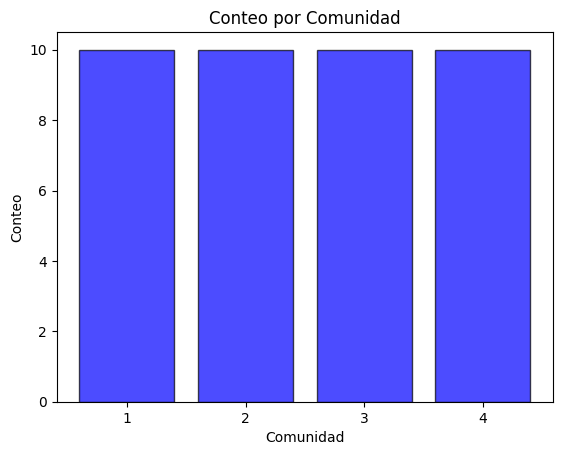

tamos en tiempo 100 con vivas 170
3
tamos en tiempo 200 con vivas 208
6
tamos en tiempo 300 con vivas 155
3
tamos en tiempo 400 con vivas 305
tamos en tiempo 500 con vivas 185
6
3
tamos en tiempo 600 con vivas 247
6
tamos en tiempo 700 con vivas 137
3
tamos en tiempo 800 con vivas 318
tamos en tiempo 900 con vivas 160
6
3
247


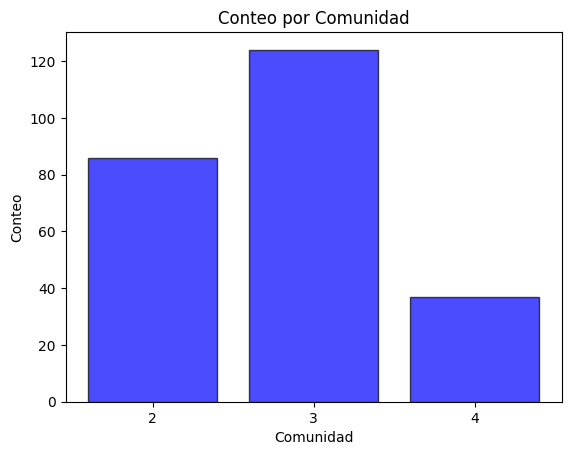

In [7]:
#Con la mitad de la media
### Parameters for simulation
iniciais = 40 # Initial UD
prob_morte = 0.06 # Beta from the gutertz equation
media = 6 # Average children per UD
random.seed(42) # Random seed
t = 1000 #steps of the simulation
UD.uds = {}

#### Initialization
## Comunidades
UD.uds = {}
comunidades_disponibles = [i for i in range(1, (int(iniciais) // 10) + 1) for _ in range(10)]
instancias_ud = []
for id_ud in range(1, int(iniciais) + 1):
    instancias_ud.append(UD(id_ud, media, comunidades_disponibles.pop(0)))
## Variedades y repartirlas entre las comunidades
for id_ud, ud in UD.uds.items():
    for _ in range(5):
        ud.varieties.append(Variety())

comunidades_lista = [ud.community for ud in UD.uds.values()]

histogram_communities(comunidades_lista)
    
#### Simulation
original_media = media
vivas = [int(iniciais)]
for i in range (1, (t)):
    uds_copy = dict(UD.uds) #As UDs existentes no tempo n
    any_ud_active = False # Flag to see if the simulation went to extintion
    alive = len([1 for id, ud in uds_copy.items() if ud.activa])
    if alive > 200 and (media == original_media): #or media == original_media-1):
        media -= media//2
        if media >= 4:
            media = media //2
        print(media)
    elif alive < 150 and media < original_media:
        media = original_media
        print(media)
    for id_ud, ud in uds_copy.items():
        if ud.activa == True:
            any_ud_active = True
            ud.ter_filho()
            ud.buscar_ud(media, 50, True)
            ud.incrementar_idade()
            ud.death_probability(prob_morte)
    if not any_ud_active:
        print("acabo")
        break
    if i % 250 == 0:
        pass
        #create_vis_geral(uds_copy, True)
        #p_graph(uds_copy, True)
     # Collecting data
    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
    vivas.append(viv)
    #mortas.append(mort)
    #tempo.append(t)
    if i%100 == 0:
        print(f"tamos en tiempo {i} con vivas {viv}")
#comunidades_lista = [ud.community for ud in UD.uds.values()]
comunidades_lista = [ud.community for id, ud in uds_copy.items() if ud.activa]
print(len([ud for id, ud in uds_copy.items() if ud.activa]))
histogram_communities(comunidades_lista)
#community_level_agrobiodiversity(UD)

In [4]:
def histogram_communities(comunidades_lista):
    # Utilizamos np.unique para obtener los valores únicos y sus frecuencias
    valores, conteos = np.unique(comunidades_lista, return_counts=True)

    # Creamos el gráfico de barras con transparencia ajustada
    plt.bar(valores, conteos, color='blue', edgecolor='black', alpha=0.7)

    # Añadimos etiquetas y título
    plt.title('Conteo por Comunidad')
    plt.xlabel('Comunidad')
    plt.ylabel('Conteo')

    # Establecemos los límites del eje x para que solo muestre números enteros
    plt.xticks(np.arange(min(valores), max(valores)+1, 1))

    # Mostramos el gráfico
    plt.show()

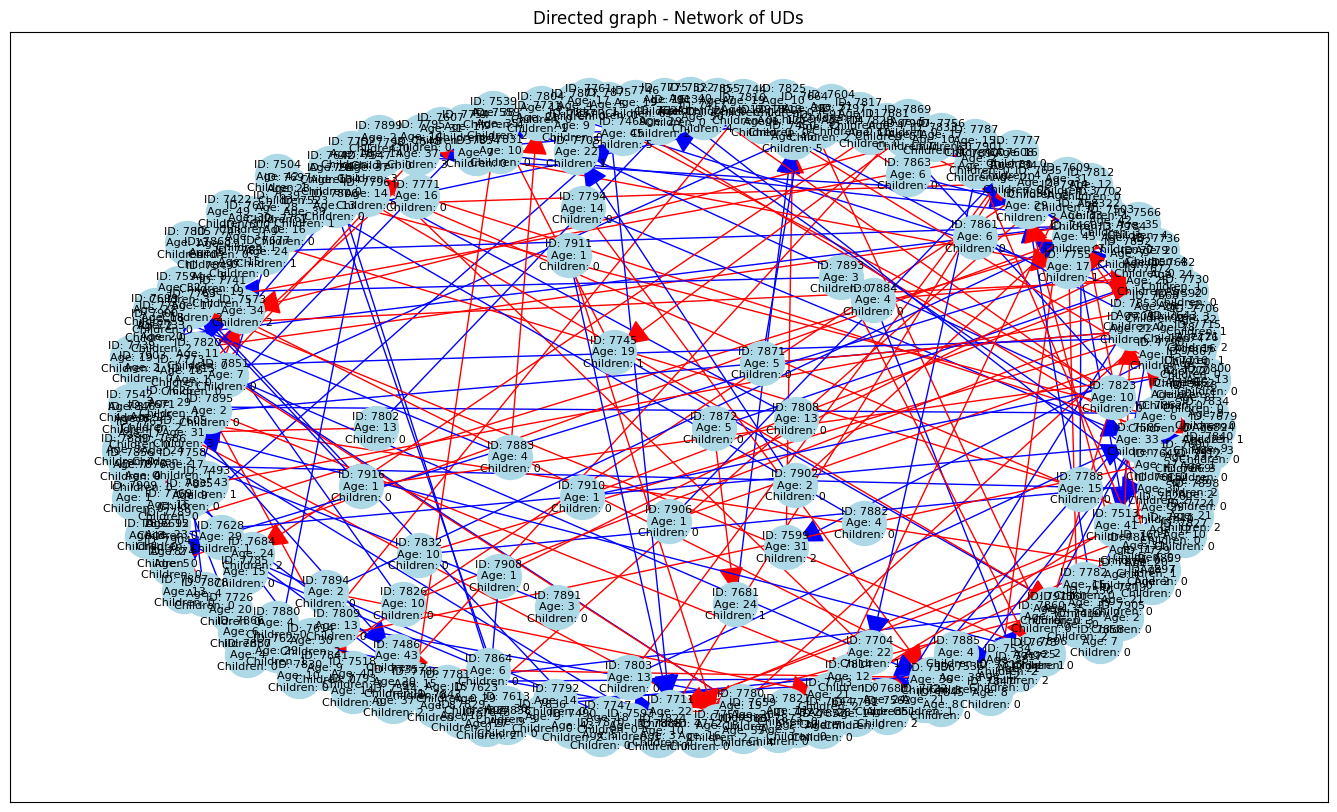

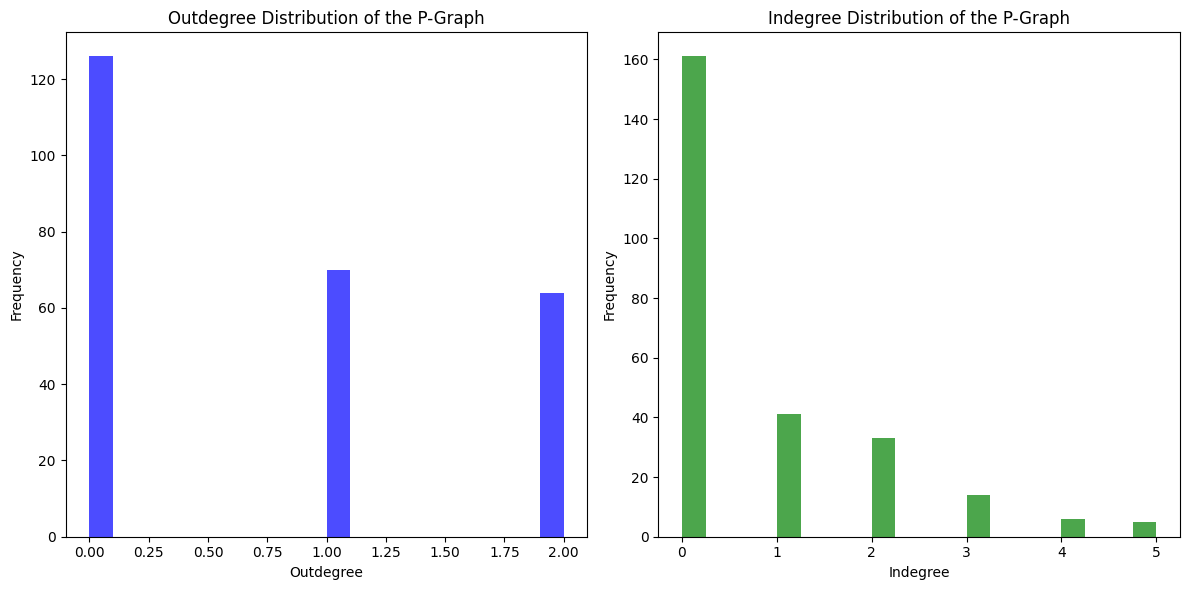

In [12]:
p_graph(UD.uds, True)

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

def p_graph(uds_copy, measures): 
    G = nx.DiGraph()
    # Alive
    ud_vivas = {id_ud: ud for id_ud, ud in uds_copy.items() if ud.activa == True}
    id_ud_vivas = [id_ud for id_ud in ud_vivas.keys()]

    # First the nodes
    for id_ud, ud in ud_vivas.items():
        G.add_node(id_ud, ID=id_ud, age=ud.age, filhos=len(ud.parentes[2]) if ud.parentes[2] is not None else 0)

    # Then to their parents
    for id_ud, ud in ud_vivas.items():
        if ud.parentes[0] is not None and ud.parentes[0] in id_ud_vivas:
            G.add_edge(id_ud, ud.parentes[0])
        if ud.parentes[1] is not None and ud.parentes[1] in id_ud_vivas:
            G.add_edge(id_ud, ud.parentes[1], color='red')  # Set edge color to red

    # Create hierarchical layout
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')

    # Draw nodes and edges
    node_labels = {node: f"ID: {G.nodes[node]['ID']}\nAge: {G.nodes[node]['age']}\nChildren: {G.nodes[node]['filhos']}" for node in G.nodes}
    edge_colors = [G[u][v].get('color', 'blue') for u, v in G.edges]  # Get edge colors
    plt.figure(figsize=(17, 10))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=True, arrowsize=40)
    plt.title("Directed graph - Network of UDs")
    plt.show()
    
    if measures == True:
        # Create histograms for outdegree and indegree
        outdegree_values = [outdegree for _, outdegree in G.out_degree()]
        indegree_values = [indegree for _, indegree in G.in_degree()]

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(outdegree_values, bins=20, color='blue', alpha=0.7)
        plt.title('Outdegree Distribution of the P-Graph')
        plt.xlabel('Outdegree')
        plt.ylabel('Frequency')

        plt.subplot(1, 2, 2)
        plt.hist(indegree_values, bins=20, color='green', alpha=0.7)
        plt.title('Indegree Distribution of the P-Graph')
        plt.xlabel('Indegree')
        plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()


In [ ]:
pip install pygraphviz

In [14]:
p_graph(UD.uds, True)

C:\Users\jsolm\AppData\Local\Temp\ipykernel_19700\16107365.py:22: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G, prog='dot')


ModuleNotFoundError: No module named 'pydot'